In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# Para plotar os resultados
from qiskit.visualization import plot_histogram

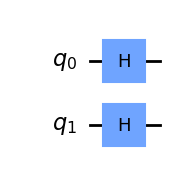

In [2]:
n = 2
grover_circuit = QuantumCircuit(n)

def initialize_s(qc, qubits):
    '''Aplicamos a Hadamard em cada qubit'''
    for q in qubits:
        qc.h(q)
    return qc

grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw('mpl')

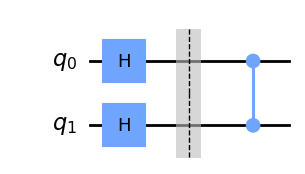

In [3]:
grover_circuit.barrier()
grover_circuit.cz(0,1) # Oráculo para 2 qubits
grover_circuit.draw('mpl')

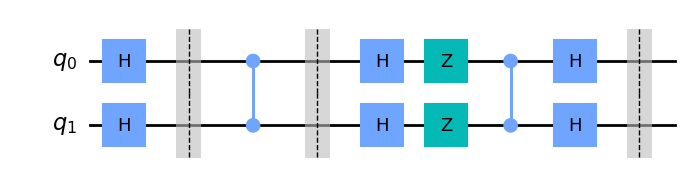

In [4]:
grover_circuit.barrier()
# Mantemos o 0 e trocamos as fases dos demais estados
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.barrier()
grover_circuit.draw('mpl')

In [5]:
sv_sim = Aer.get_backend('statevector_simulator')

result = sv_sim.run(grover_circuit).result()

statevec = result.get_statevector()
from qiskit.visualization import array_to_latex
array_to_latex(statevec, prefix="|\\psi\\rangle =")

<IPython.core.display.Latex object>

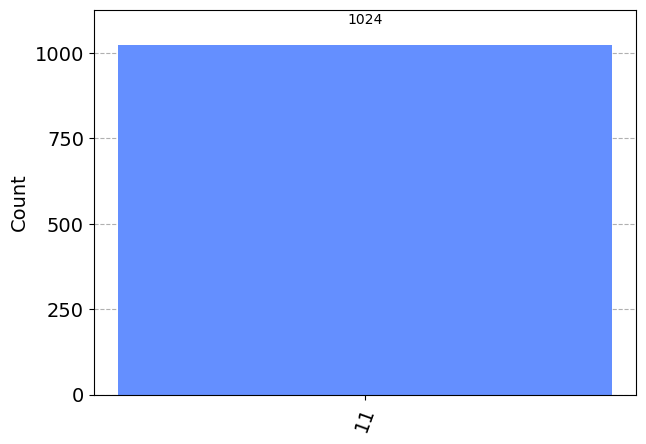

In [6]:
grover_circuit.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(grover_circuit).result()
counts = result.get_counts()
plot_histogram(counts)

## Resolvendo um Sudoku
Vamos usar o Grover para encontrar a solução para o seguinte sudoku
![](./Sudoku.png)

Pelas regras precisamos que: $v_0 \neq v_1, v_2 \neq v_3 , v_0 \neq v_2, v_1 \neq v_3$

Usamos um circuito clássico para testar cada uma das regras acima.

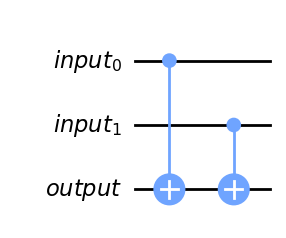

In [7]:
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)

# Criamos umm registro para armazenar a informação sobre os qubits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw('mpl')

Neste circuito, apenas quando $input_0 \neq input_1$ o output será 1.

Fazemos um teste semelhante para cada um dos 4 casos mencionados

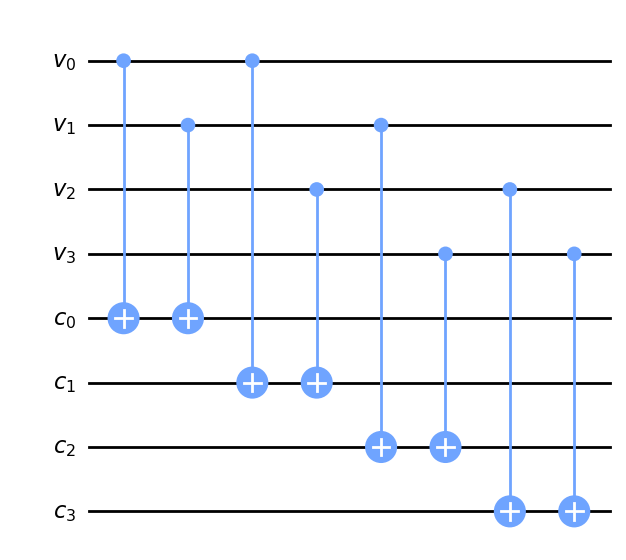

In [8]:
clause_list = [ [0,1],
               [0,2],
               [1,3],
               [2,3] ]


var_qubits = QuantumRegister(4, name='v')  # Qubits de trabalho
clause_qubits = QuantumRegister(4, name='c')  # Qubits para armazenar os testes

# Circuito
qc = QuantumCircuit(var_qubits, clause_qubits)

# testar cada caso
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw('mpl')

Aqui, apenas teremos $|c_0, c_1, c_2, c_3\rangle = |1,1,1,1\rangle$ se os inputs forem solução do sudoku. Vamos adicionar novo qubit $output$ que será 1 apenas se todos os $c$ forem 1 usando uma perta Toffoli multi-controlada `mct`. Este será o nosso oráculo.

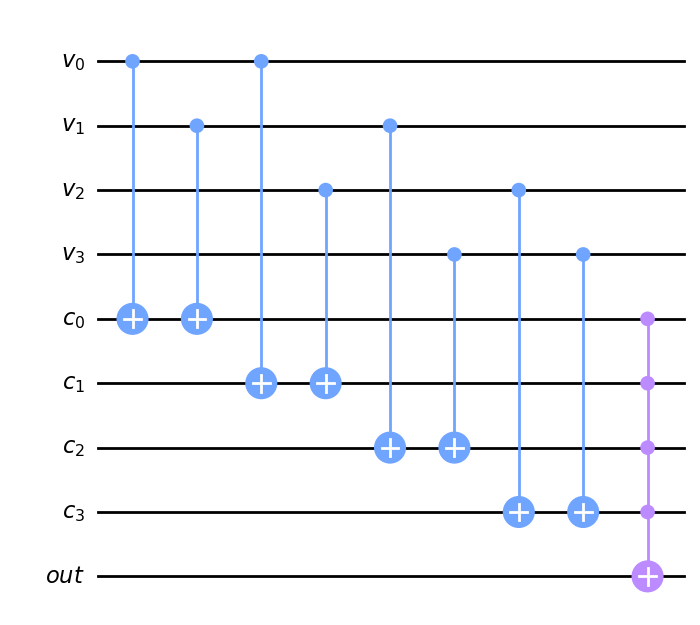

In [9]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# Flipar o 'output' apenas se todos os 'c' forem 1
qc.mct(clause_qubits, output_qubit)

qc.draw('mpl')

O Grover exige que o oráculo marque a resposta correta, com um sinal negativo, para isto, podemos exigir que o qubit $out$ seja inicializado no estado $|-\rangle$, já que, $X|-\rangle=-|-\rangle$

$$
\begin{eqnarray}
 U_w |x\rangle|0\rangle|-\rangle =
\left\{
\begin{array}{cc}
 |x\rangle|0\rangle|-\rangle & , x = w \\
 -|x\rangle|0\rangle|-\rangle & , x \neq w\\
\end{array}
\right.
\end{eqnarray}
$$

O circuito completo do nosso oráculo será

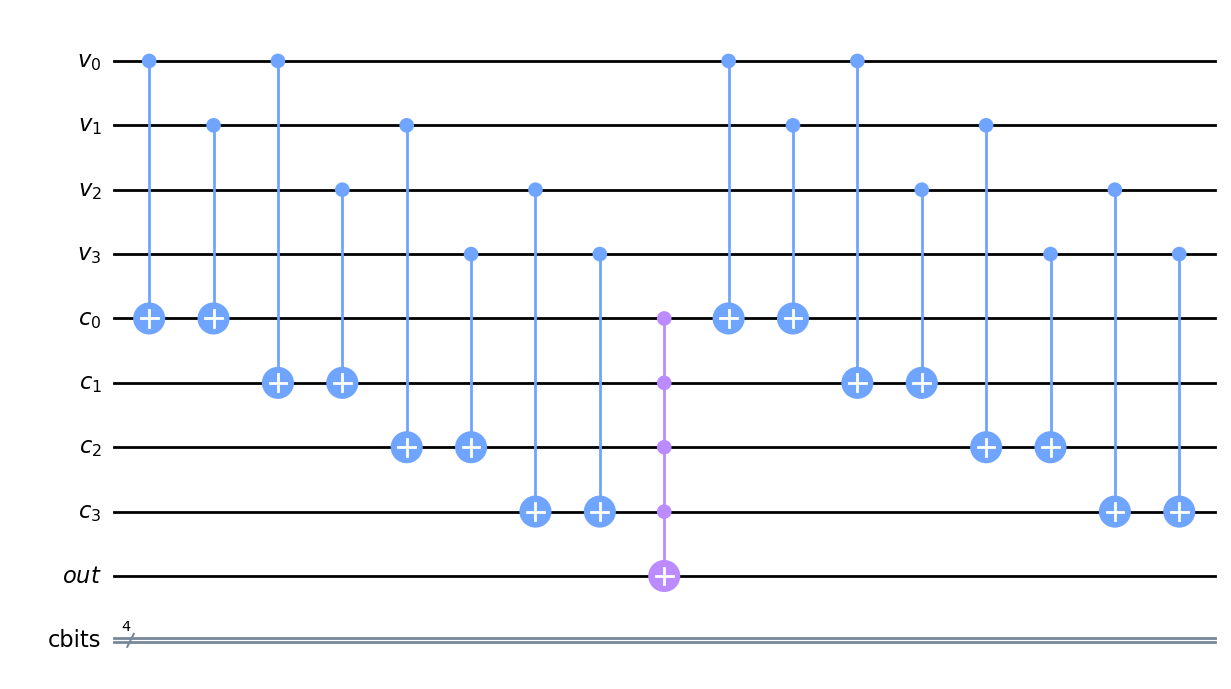

In [10]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw('mpl')

O difusor, por sua vez, é a operação que inverte o sinal de todos os qubits exceto o $|0\rangle$. Uma forma de criar um difusor genérico é aplicando a transformação:
$U_S = H X (MCZ) X H$

In [11]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

Podemos então, rodar o circuito completo com duas iterações

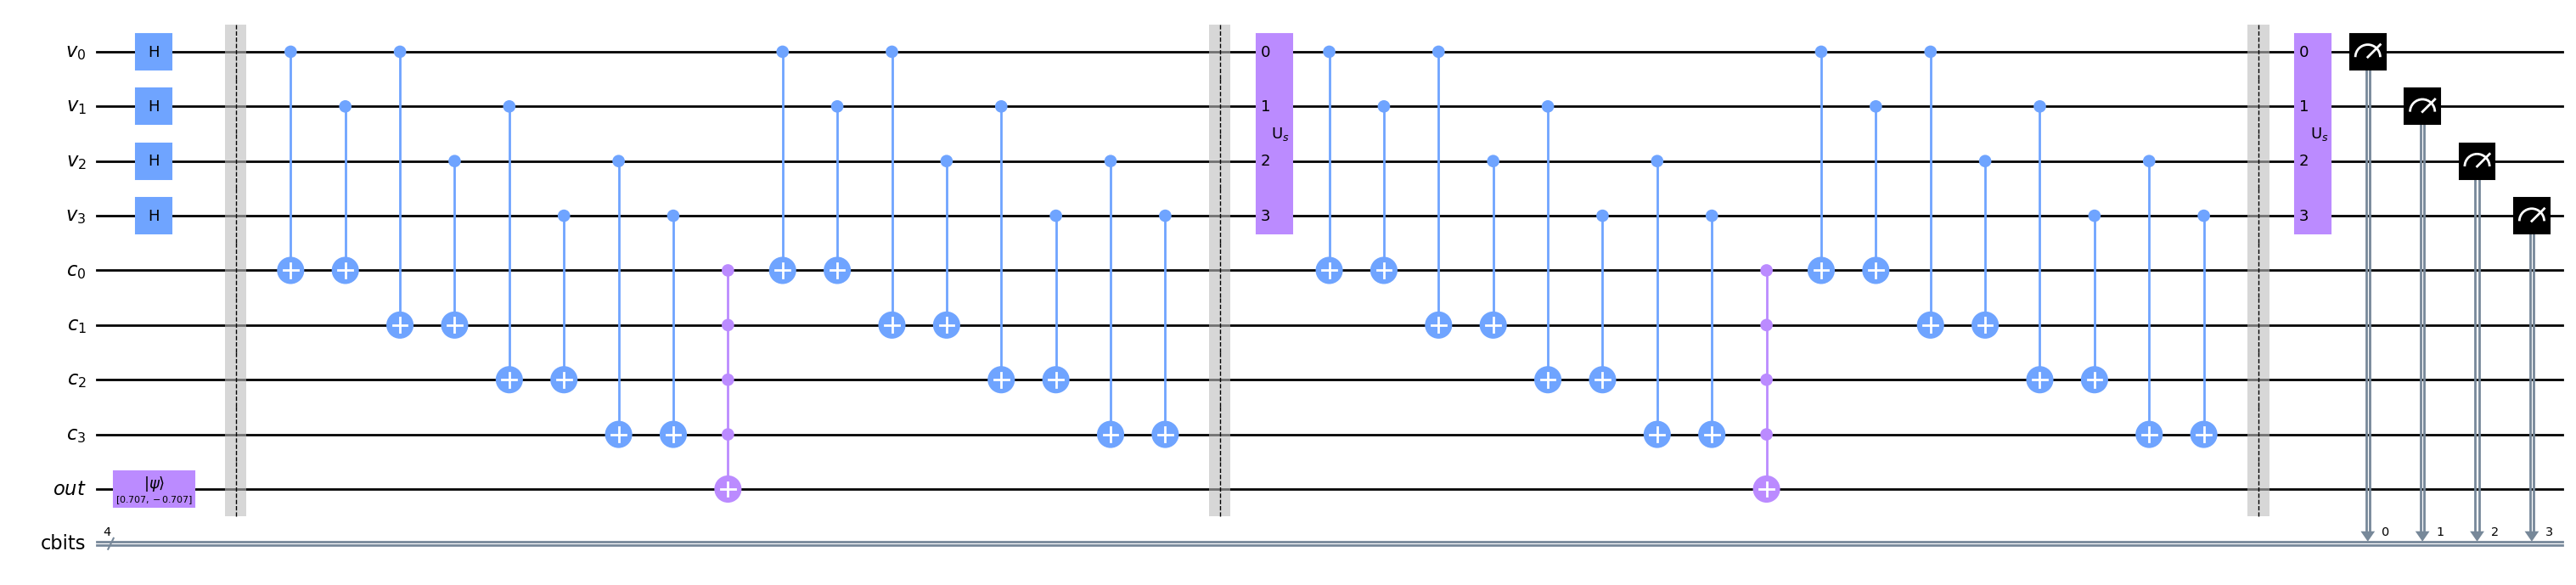

In [12]:
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Inicializar 'out0' no estado |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Inicializar os qubits no estado |s>
qc.h(var_qubits)
qc.barrier()

## Primeira iteração
# Oráculo
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()

# Difusor
qc.append(diffuser(4), [0,1,2,3])

## Segunda iteração
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  

qc.append(diffuser(4), [0,1,2,3])

# Medida
qc.measure(var_qubits, cbits)

qc.draw('mpl', fold=-1)

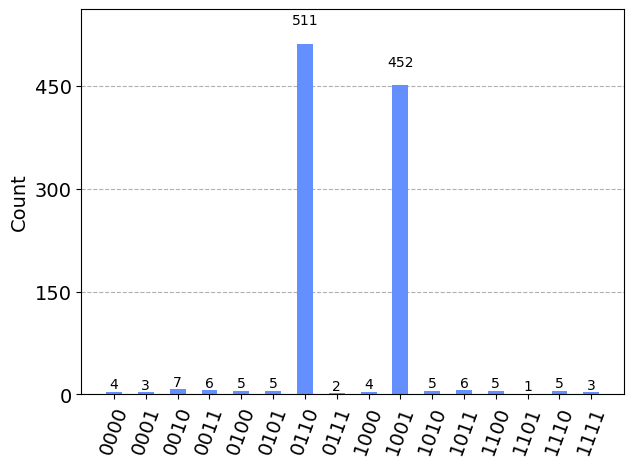

In [13]:
# Simulando os resultados
qasm_simulator = Aer.get_backend('qasm_simulator')
transpiled_qc = transpile(qc, qasm_simulator)
result = qasm_sim.run(transpiled_qc).result()
plot_histogram(result.get_counts())